In [1]:
import sys
import pickle
sys.path.append("../tools/")
import pandas
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
# You will need to use more features
email_features_list=['from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]

financial_features_list=['bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]

features_list = ['poi']+email_features_list + financial_features_list 
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
#Dataset exploration
print ('Exploratory Data Analysis')
data_dict.keys()
print ('Total number of data points= {0}').format(len(data_dict.keys()))

count_poi=0
for name in data_dict.keys():
    if data_dict[name]['poi']==True:
        count_poi+=1

print ('Number of Persons of Interest: {0}').format(count_poi)
print ('Number of Non-Person of Interest: {0}').format(len(data_dict.keys())-count_poi)


Exploratory Data Analysis
Total number of data points= 146
Number of Persons of Interest: 18
Number of Non-Person of Interest: 128


In [3]:
##Feature exploration
# Find missing data
all_features=data_dict['BAXTER JOHN C'].keys()
print ('Total Features everyone on the list has:', len(all_features))

missing={}
for feature in all_features:
    missing[feature]=0

for person in data_dict:
    records=0
    for feature in all_features:
        if data_dict[person][feature]=='NaN':
            missing[feature]+=1
        else:
            records+=1

print ('Number of Missing Values for each Feature:')
for feature in all_features:
    print (feature, missing[feature])

('Total Features everyone on the list has:', 21)
Number of Missing Values for each Feature:
('salary', 51)
('to_messages', 60)
('deferral_payments', 107)
('total_payments', 21)
('exercised_stock_options', 44)
('bonus', 64)
('restricted_stock', 36)
('shared_receipt_with_poi', 60)
('restricted_stock_deferred', 128)
('total_stock_value', 20)
('expenses', 51)
('loan_advances', 142)
('from_messages', 60)
('other', 53)
('from_this_person_to_poi', 60)
('poi', 0)
('director_fees', 129)
('deferred_income', 97)
('long_term_incentive', 80)
('email_address', 35)
('from_poi_to_this_person', 60)


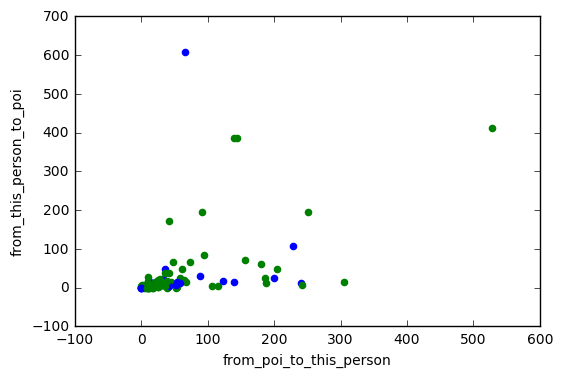

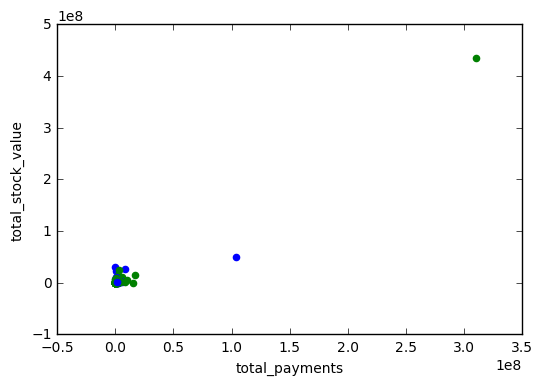

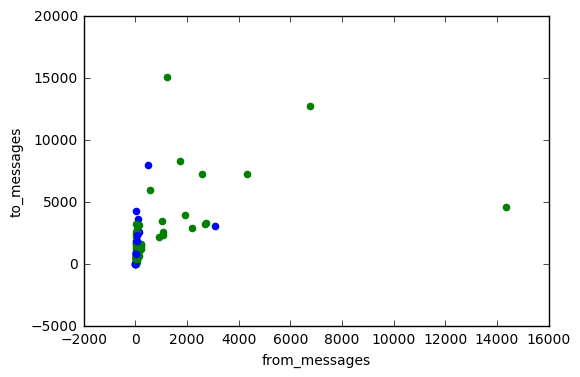

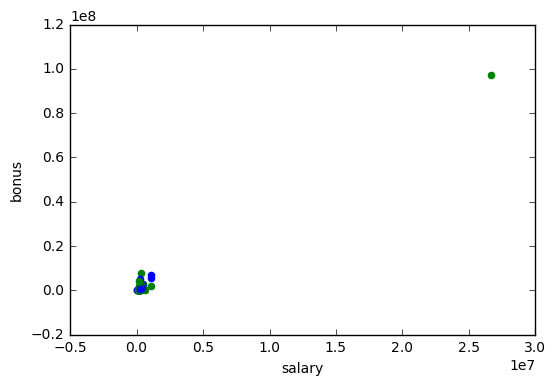

In [4]:
### Task 2: Remove outliers

#make it into a function based on the multiple variables
def PlotOutlier(data_dict, ax, ay):
    data = featureFormat(data_dict, [ax,ay,'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi=point[2]
        if poi:
            color='blue'
        else:
            color='green'

        plt.scatter( x, y, color=color )
    plt.xlabel(ax)
    plt.ylabel(ay)
    plt.show()
PlotOutlier(data_dict, 'from_poi_to_this_person','from_this_person_to_poi')
PlotOutlier(data_dict, 'total_payments', 'total_stock_value')
PlotOutlier(data_dict, 'from_messages','to_messages')
PlotOutlier(data_dict, 'salary','bonus')

##function to remove outliers
def remove_outliers(data_dict, outliers):
    for outlier in outliers:
        data_dict.pop(outlier, 0)
outliers =['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHARD EUGENE E']
remove_outliers(data_dict, outliers)

In [5]:
##function to remove outliers
def remove_outliers(data_dict, outliers):
    for outlier in outliers:
        data_dict.pop(outlier, 0)
outliers =['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHARD EUGENE E']
remove_outliers(data_dict, outliers)

In [6]:
### Task 3: Create new feature(s) that will help identify POI
### Store to my_dataset for easy export below.
my_dataset = data_dict

##Add new features to dataset


def computeFraction( poi_messages, all_messages ):
    """ given a number messages to/from POI (numerator) 
        and number of all messages to/from a person (denominator),
        return the fraction of messages to/from that person
        that are from/to a POI
   """
    fraction = 0.
    if all_messages =='NaN':
        return fraction
    if poi_messages=='NaN':
        return fraction
        
    fraction=float(poi_messages)/float(all_messages)
    return fraction
submit_dict={}
for name in my_dataset:

    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    submit_dict[name]={"from_poi_to_this_person":fraction_from_poi,
                       "from_this_person_to_poi":fraction_to_poi}
    data_point["fraction_to_poi"] = fraction_to_poi


my_feature_list=features_list+['from_poi_to_this_person','to_messages','fraction_from_poi','from_this_person_to_poi',
                               'from_messages','fraction_to_poi']

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import cross_validation
from sklearn.svm import SVC


def getkbest(data_dict, features_list, k):
    data=featureFormat(my_dataset, features_list)
    labels, features = targetFeatureSplit(data)
    selection=SelectKBest(k=k).fit(features,labels)
    scores=selection.scores_
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs=list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    selection_best = dict(sorted_pairs[:k])
    return selection_best
num=12 
best_features = getkbest(my_dataset, my_feature_list, num)
print ('Selected features and their scores: ', best_features)
my_feature_list = ['poi'] + best_features.keys()
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

('Selected features and their scores: ', {'salary': 18.289684043404513, 'total_payments': 8.7727777300916792, 'loan_advances': 7.1840556582887247, 'bonus': 20.792252047181535, 'total_stock_value': 24.182898678566879, 'shared_receipt_with_poi': 8.589420731682381, 'fraction_to_poi': 16.409712548035799, 'exercised_stock_options': 24.815079733218194, 'deferred_income': 11.458476579280369, 'expenses': 6.0941733106389453, 'restricted_stock': 9.2128106219771002, 'long_term_incentive': 9.9221860131898225})
12 selected features: ['salary', 'total_payments', 'loan_advances', 'bonus', 'total_stock_value', 'shared_receipt_with_poi', 'fraction_to_poi', 'exercised_stock_options', 'deferred_income', 'expenses', 'restricted_stock', 'long_term_incentive']



In [7]:
### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
features=scaler.fit_transform(features)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

In [9]:
#DecisionTree
clf_d=Pipeline([
    ('standardscaler',StandardScaler()),
    ('pca',PCA()),
    ('clf_d',DecisionTreeClassifier(criterion='gini', max_depth=6, min_samples_leaf=2, min_samples_split=7, splitter='best',random_state=42))])


clf_p=Pipeline([
    ('standardscaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l2', tol=0.001, C=0.0000001, random_state=42))])

from sklearn.cluster import KMeans
clf_k=Pipeline([
    ('standardscaler',StandardScaler()),
    ('pca',PCA()),
    ('clf_k',KMeans(n_clusters=2, random_state=42, tol=0.001))])

from sklearn.svm import SVC
clf_s=Pipeline([
    ('standardscaler',StandardScaler()),
    ('pca',PCA()),
    ('clf_s',SVC(kernel='rbf',C = 1000,random_state = 42))])


from sklearn.naive_bayes import GaussianNB
clf_g=Pipeline(steps=[
    ('standardscaler',StandardScaler()),
    ('pca',PCA()),
    ('clf_g',GaussianNB())])

from sklearn.ensemble import RandomForestClassifier
clf_rf =Pipeline( [
    ('standardscaler',StandardScaler()),
    ('pca',PCA()),
    ('clf_rf',RandomForestClassifier())]) 

In [10]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
def evaluate(clf, features, labels, num=1000):
    print (clf)
    accuracy=[]
    precision=[]
    recall=[]
    for trial in range(num):
        features_train, features_test, labels_train, labels_test=\
                        cross_validation.train_test_split(features, labels, test_size=0.3, random_state=42)
        clf=clf.fit(features_train, labels_train)
        pred=clf.predict(features_test)
        accuracy.append(clf.score(features_test, labels_test))
        precision.append(precision_score(labels_test, pred))
        recall.append(recall_score(labels_test, pred))
    print ('precision: {}').format(np.mean(precision))
    print ('recall: {}').format(np.mean(recall))
    return np.mean(precision), np.mean(recall), confusion_matrix(labels_test, pred),classification_report(labels_test, pred) 

In [11]:
print 'KMeans: ',evaluate(clf_k, features, labels)       


KMeans:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf_k', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.001, verbose=0))])


/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


precision: 0.0
recall: 0.0
(0.0, 0.0, array([[38,  0],
       [ 5,  0]]), '             precision    recall  f1-score   support\n\n        0.0       0.88      1.00      0.94        38\n        1.0       0.00      0.00      0.00         5\n\navg / total       0.78      0.88      0.83        43\n')


/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
print 'Gaussian: ',evaluate(clf_g, features, labels)


Gaussian:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf_g', GaussianNB(priors=None))])
precision: 0.5
recall: 0.6
(0.5, 0.59999999999999976, array([[35,  3],
       [ 2,  3]]), '             precision    recall  f1-score   support\n\n        0.0       0.95      0.92      0.93        38\n        1.0       0.50      0.60      0.55         5\n\navg / total       0.89      0.88      0.89        43\n')


In [13]:
print 'Linear Regression: ', evaluate(clf_p, features, labels)


Linear Regression:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1e-07, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False))])
precision: 0.333333333333
recall: 0.6
(0.33333333333333326, 0.59999999999999976, array([[32,  6],
       [ 2,  3]]), '             precision    recall  f1-score   support\n\n        0.0       0.94      0.84      0.89        38\n        1.0       0.33      0.60      0.43         5\n\navg / total       0.87      0.81      0.84        43\n')


In [14]:
print 'Random Forest: ',evaluate(clf_rf, features, labels)


Random Forest:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf_rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini'...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
precision: 0.534796428571
recall: 0.2976
(0.53479642857142862, 0.29760000000000003, array([[36,  2],
       [ 4,  1]]), '             precision    recall  f1-score   support\n\n        0.0       0.90      0.95      0.92        38\n        1.0       0.33      0.20      0.25         5\n\navg / total       0.83      0.86      0.84        43\n')


In [15]:
print 'SVC: ', evaluate(clf_s, features, labels)


SVC:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf_s', SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
precision: 0.0
recall: 0.0
(0.0, 0.0, array([[34,  4],
       [ 5,  0]]), '             precision    recall  f1-score   support\n\n        0.0       0.87      0.89      0.88        38\n        1.0       0.00      0.00      0.00         5\n\navg / total       0.77      0.79      0.78        43\n')


In [16]:
print 'Decision Tree: ', evaluate(clf_d, features, labels)

Decision Tree:  Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf_d', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
  ...plit=7, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best'))])
precision: 0.166666666667
recall: 0.2
(0.16666666666666663, 0.20000000000000004, array([[33,  5],
       [ 4,  1]]), '             precision    recall  f1-score   support\n\n        0.0       0.89      0.87      0.88        38\n        1.0       0.17      0.20      0.18         5\n\navg / total       0.81      0.79      0.80        43\n')


In [17]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
# Example starting point. Try investigating other evaluation techniques!
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report
from sklearn.cross_validation import StratifiedShuffleSplit

skb = SelectKBest()
pca = PCA()
gnb = GaussianNB()
k_range = [6, 8, 10, 12]
PCA_range = [2, 3, 4, 5, 6]

steps = [('scaling',scaler), ('SKB', skb), ('pca',pca), ('algorithm', gnb)]
pipeline = Pipeline(steps)

parameters_gnb = {
        'SKB__k' : k_range,
        'pca__n_components' : PCA_range}

cv = StratifiedShuffleSplit(labels, n_iter=20, random_state = 42)

gs_gnb = GridSearchCV(pipeline, parameters_gnb, n_jobs = -1, cv=cv, scoring="f1")

gs_gnb.fit(features, labels)
clf = gs_gnb.best_estimator_


/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Pikatsou/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
print 'best estimator: ',gs_gnb.best_estimator_
print 'best parameter: ',gs_gnb.best_params_

best estimator:  Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=12, score_func=<function f_classif at 0x10cfe35f0>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', GaussianNB(priors=None))])
best parameter:  {'pca__n_components': 5, 'SKB__k': 12}


In [20]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
from tester import test_classifier

test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('SKB', SelectKBest(k=12, score_func=<function f_classif at 0x10cfe35f0>)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('algorithm', GaussianNB(priors=None))])
	Accuracy: 0.83220	Precision: 0.36951	Recall: 0.36600	F1: 0.36775	F2: 0.36670
	Total predictions: 15000	True positives:  732	False positives: 1249	False negatives: 1268	True negatives: 11751



### 